# Project 2: Reinforcement Learning agent to play Snake

In [ ]:
#use of google drive to import environment
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os
os.chdir('/content/drive/MyDrive/AP_Assignement2')

In [ ]:
!ls

## 1 Basic DQN Implementation without Experience Replay and Target network

### 1.1 Set up the neural network architecture

In [ ]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from snake_game import SnakeGame
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Select the corresponding device
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [ ]:
# Define the hyperparameters
N_ACTIONS       = 3        # A = [left,forward,right] = [-1,0,1]
BOARD_SIZE      = 30       # Grid without boarder
BORDER          = 1        # Size of the boarder for each extremity
IN_CHANNELS     = 1        # Number of channels of the image (here we used rgb images but we actually use a grayscale version)
EPS_START       = 1.0      # Initial value of epsilon for the epsilon-greedy strategy
EPS_END         = 0.05     # Final value of epsiolon
EPS_DECAY       = 10000    # controls the rate of exponential decay of epsilon, higher means a slower decay
GAMMA           = 0.99     # Discount factor
LR              = 1e-4     # Learning rate
MAX_EPISODES = 1000        # Maximum number of episodes (doesn't include the episodes using heuristic)
PRETRAIN_EPISODES   = 15 # Maximum number of episodes using the heuristic function
MAX_STEPS       = 1000     # Maximum number of steps within an episode

assert PRETRAIN_EPISODES <= MAX_EPISODES, "You can't have more pretrain episodes than the total number of episodes"

In [ ]:
def preprocess(board):
    """
    Preprocess the board given by the function board_state(). It is a numpy array of shape (height,width,3).
    Therefore we want to transform this numpy image into a pytorch tensor of format [1,1,32,32] (1 batch, 1 channel,h,w)
    input: a frame corresponding to the current state of the game gird
    output: the preprocessed frame
    """
    gray = 0.2989 * board[:, :, 0] + 0.5870 * board[:, :, 1] + 0.1140 * board[:, :, 2]
    tensor = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0)
    return tensor.to(torch.float32).to(device)

In [ ]:
# Here we use a CNN model that will take as an input a preprocessed frame of the grid of the game
# And will provide as an output the Q-values for each possible actions
# Reminder: Conv2D(in_channels,out_channels,kernel_size,stride)
#
class DQN(nn.Module):
    def __init__(self, input_channels=IN_CHANNELS, num_actions=N_ACTIONS):
        super(DQN,self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.conv3 = nn.Conv2d(32, 32, 2, 1)
        self.fc1   = nn.Linear(800, 512)
        self.fc2   = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # x is still a 4D tensor at that point, therefore we need to flatten it before fc1
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

policy_net = DQN()
policy_net = policy_net.to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

### 1.2 Define and implement the Q-learning loss function

In [ ]:
# Define the batch
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward', 'done'))

In [ ]:
def Q_learning_loss(policy_net, batch):
    """
    Loss function that computes the difference between the predicted Q-values and the target Q-values.
    Input: policy_net: model taking the images of the grid and computing the action to take
            batch: transion with the state, next_state, action and reward
    Output: Return the loss in a format of a scalar
    """
    # Q(s,a)
    q_pred = policy_net(batch.state).gather(1, batch.action)

    with torch.no_grad():
        # max of a' on Q(s',a')
        q_next = policy_net(batch.next_state).max(1, keepdim=True).values
        # r + GAMME * maxS(s',a')
        q_target = batch.reward + GAMMA * q_next

    mse = nn.MSELoss()
    # (r + GAMME * maxS(s',a') - Q(s,a))²
    return mse(q_target,q_pred)


In [ ]:
# Small test to verify that everything is fine and doesn't produce errors during execution
s      = torch.rand(1, 1, 32, 32, device=device)
s_next = torch.rand(1, 1, 32, 32, device=device)
a      = torch.tensor([[1]], device=device)
r      = torch.tensor([[0.5]], device=device)
d      = torch.tensor([[0]], device=device)

batch  = Transition(s, a, s_next, r, d)
loss   = Q_learning_loss(policy_net, batch)
print(loss.item())

0.24701689183712006


### 1.3 Implement the training loop and evaluation

In [ ]:
scores = []
losses = []
apples = []
steps_done = 0

env = SnakeGame(BOARD_SIZE, BOARD_SIZE, border=BORDER)

for ep in range(1, MAX_EPISODES + 1):

    board, _, done, info = env.reset()
    state = preprocess(board)
    ep_ret = 0
    apples_ep = 0

    for t in range(MAX_STEPS):
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-steps_done / EPS_DECAY)
        q_values = policy_net(state)

        # Exploration
        if torch.rand(1).item() < eps:
            action_idx = torch.randint(0, N_ACTIONS, (1,), device=device)
        # Exploitation
        else:
            action_idx = torch.argmax(q_values, dim=1)

        # Go from [0,1,2] to [-1,0,1]
        action = int(action_idx.item()) - 1
        next_board, reward, done, info = env.step(action)
        if reward > 0:
            apples_ep += 1
        next_state = preprocess(next_board)

        batch = Transition(state,
                           action_idx.view(1,1),
                           next_state,
                           torch.tensor([[reward]], dtype=torch.float32, device=device),
                           torch.tensor([[float(done)]], dtype=torch.float32, device=device))

        loss = Q_learning_loss(policy_net, batch)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
        optimizer.step()
        losses.append(loss.item())
        state = next_state

        if not done:
            reward += 0.1
        ep_ret += reward
        steps_done += 1
        # Finish the episode if the snake died
        if done:
            break

    scores.append(ep_ret)
    apples.append(apples_ep)

    if ep % 100 == 0:
        avg_score = sum(scores[-100:]) / 100
        avg_loss  = sum(losses[-100*min(MAX_STEPS,100):]) / (100*min(MAX_STEPS,100))
        print(f"Episode: {ep}. Average score: {avg_score}. Loss: {avg_loss}. Epsilon: {eps}")

Episode: 100. Average score: 0.8470000000000002. Loss: 0.009737022405950644. Epsilon: 0.9406296204001342
Episode: 200. Average score: 1.109. Loss: 0.019788462213687002. Epsilon: 0.8785097882837768
Episode: 300. Average score: 1.2629999999999997. Loss: 0.02983599956259501. Epsilon: 0.8165209152210511
Episode: 400. Average score: 1.617999999999999. Loss: 0.039937952505066515. Epsilon: 0.7508276435818579
Episode: 500. Average score: 0.966. Loss: 0.04344390263937207. Epsilon: 0.7046246281697898
Episode: 600. Average score: 1.3139999999999992. Loss: 0.04269313116703772. Epsilon: 0.6544155660365082
Episode: 700. Average score: 1.6339999999999986. Loss: 0.04125509165107791. Epsilon: 0.6019524959954218
Episode: 800. Average score: 1.4169999999999996. Loss: 0.042561415422764655. Epsilon: 0.5580409144517229
Episode: 900. Average score: 1.7539999999999984. Loss: 0.03865745341327052. Epsilon: 0.5120910661769172
Episode: 1000. Average score: 1.5889999999999986. Loss: 0.03852812761895136. Epsilon: 0

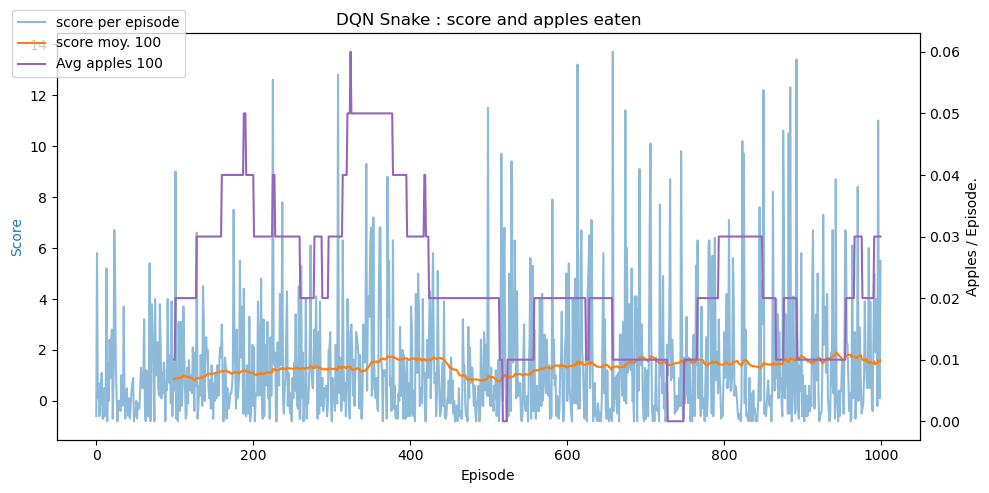

In [ ]:
window = 100
avg_scores  = np.convolve(scores,  np.ones(window)/window, mode='valid')
avg_apples  = np.convolve(apples, np.ones(window)/window, mode='valid')

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel("Episode")
ax1.set_ylabel("Score", color="tab:blue")
ax1.plot(scores, alpha=0.5, label="score per episode")
ax1.plot(np.arange(window-1, len(scores)), avg_scores, label=f"score moy. {window}")

ax2 = ax1.twinx()
ax2.set_ylabel("Apples / Episode.")
ax2.plot(np.arange(window-1, len(apples)), avg_apples, color="tab:purple", label=f"Avg apples {window}")

lines, labels = [], []
for ax in fig.axes:
    for l in ax.get_lines():
        lines.append(l); labels.append(l.get_label())
fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(0.01,0.99))

plt.title("DQN Snake : score and apples eaten")
plt.tight_layout()
plt.show()


### 1.4 Implement an heuristic policy

In [ ]:
LEFT = -1
STRAIGHT = 0
RIGHT = 1
DIRS = {0:(-1,0), 1:(0,1), 2:(1,0), 3:(0,-1)}

def heuristic(state, height, width):
    """
    Heuristic based on the Manhattan distance. It will compute which direction to take in order to
    reduce the Manhattan distance and to avoid collisions with the border or itself
    Input: state: tuple containing the position of the head of the snake, the position of the apple,
    the direction of the snake and the postion of its tail
    Input: height: value of the height of the grid of the game
    Input: width: value of the width of the grid of the game
    Output: The action that the snake should take (i.e the direction to go to)
    """
    h_row,h_col = state[2] # Position of the head
    a_row,a_col = state[1][0] # Position of the first apple
    dx,dy = a_col-h_col, a_row-h_row
    current_dir = state[4]
    tail_set = set(state[3]) # Position of each block of the snape except the head

    # Directions: north=0, est=1, south=2, west=3   (The schema is to help visualize the directions)
    #      0 y-
    #       |
    # 3 x- --- x+ 1
    #       |
    #      2 y+

    if abs(dx) > abs(dy):
        # Case: the biggest distance is horizontal and the snake is on the left of the apple
        if dx > 0:
            target_dir = 1

        # Case: the biggest distance is horizontal and the snake is on the right of the apple
        else:
            target_dir = 3
    else:
        # Case: the biggest distance is vertical and the snake is above the apple
        if dy > 0:
            target_dir = 2
        # Case: the biggest distance is vertical and the snake is below the apple
        else:
            target_dir = 0

    best_action = STRAIGHT
    best_dist = height*width # Initialize with a higher value than anything possible so that the first safe action is better
    safe_actions = []

    # Compute for every possible actions the new position of the head of the snake
    for action in (LEFT,STRAIGHT,RIGHT):
        direction = (current_dir + action) % 4
        mov_row, mov_col = DIRS[direction]
        new_h_row, new_h_col =  h_row + mov_row, h_col + mov_col

        if 0 <= new_h_row <= height and 0 <= new_h_col <= width: # Verify it doesn't collide with the border
            if not (new_h_row, new_h_col) in tail_set: # Verify it doesn't collide with its tail
                safe_actions.append(action)
                dist = abs(new_h_col - a_col) + abs(new_h_row - a_row)
                if dist < best_dist:
                    best_dist = dist
                    best_action = action

    return best_action

#### New training loop using the heuristic function

In [ ]:
scores = []
losses = []
apples = []
steps_done = 0

env = SnakeGame(BOARD_SIZE, BOARD_SIZE, border=BORDER)

for ep in range(1, MAX_EPISODES + 1):

    board, _, done, info = env.reset()
    state_img = preprocess(board)
    ep_ret = 0
    apples_ep = 0

    for t in range(MAX_STEPS):
        game_state = env.get_state()

        # Select the heuristic if we are in training mode
        if ep < PRETRAIN_EPISODES:
            action = heuristic(game_state, BOARD_SIZE+2*BORDER, BOARD_SIZE+2*BORDER)
            next_board, reward, done, info = env.step(action)
        # Else select the action based on the epsilon-greedy algorithm
        else:
            eps = EPS_END + (EPS_START - EPS_END) * math.exp(-steps_done / EPS_DECAY)
            q_values = policy_net(state_img)
            if torch.rand(1).item() < eps:
                action_idx = torch.randint(0, N_ACTIONS, (1,), device=device)
            else:
                action_idx = torch.argmax(q_values, dim=1)
            # Go from [0,1,2] to [-1,0,1]
            action = int(action_idx.item()) - 1
            next_board, reward, done, info = env.step(action)

        if reward > 0:
            apples_ep += 1

        next_state_img = preprocess(next_board)

        action_idx = torch.tensor([[action + 1]], device=device)
        batch = Transition(state_img,
                        action_idx,
                        next_state_img,
                        torch.tensor([[reward]], dtype=torch.float32, device=device),
                        torch.tensor([[float(done)]], dtype=torch.float32, device=device))

        loss = Q_learning_loss(policy_net, batch)
        optimizer.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
        optimizer.step()
        losses.append(loss.item())

        state_img = next_state_img

        # if not done:
        #     reward += 0.1
        ep_ret += reward
        steps_done += 1
        # Finish the episode if the snake died
        if done:
            break

    scores.append(ep_ret)
    apples.append(apples_ep)

    if ep % 100 == 0:
        avg_score = sum(scores[-100:]) / 100
        avg_loss  = sum(losses[-100*min(MAX_STEPS,100):]) / (100*min(MAX_STEPS,100))
        print(f"Episode: {ep}. Average score: {avg_score}. Loss: {avg_loss}. Epsilon: {eps}")

Episode: 100. Average score: 4.51. Loss: 0.04895698138739228. Epsilon: 0.3049741033712813
Episode: 200. Average score: -0.99. Loss: 0.04815033163394118. Epsilon: 0.2531738435221131
Episode: 300. Average score: -1.0. Loss: 0.04720154950932688. Epsilon: 0.21180015855925527
Episode: 400. Average score: -0.98. Loss: 0.04507695890275677. Epsilon: 0.17553216048585563
Episode: 500. Average score: -0.99. Loss: 0.04566344567155459. Epsilon: 0.1509436039940461
Episode: 600. Average score: -0.99. Loss: 0.04479176987884886. Epsilon: 0.1338527248611559
Episode: 700. Average score: -0.97. Loss: 0.04858414805069696. Epsilon: 0.11997667586485275
Episode: 800. Average score: -0.99. Loss: 0.051181848874964395. Epsilon: 0.10907819967853835
Episode: 900. Average score: -0.95. Loss: 0.055711795111865664. Epsilon: 0.09945494161359907
Episode: 1000. Average score: -0.97. Loss: 0.05919760465705051. Epsilon: 0.09139093868758114


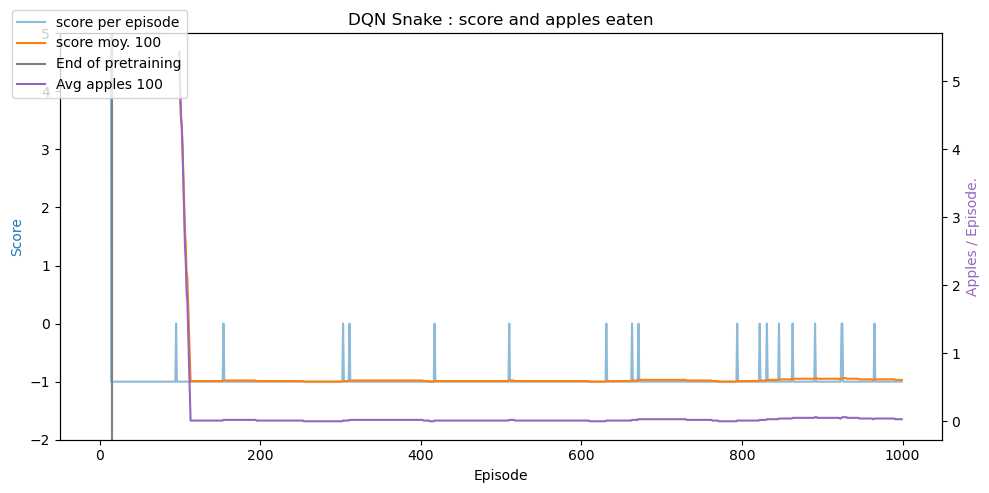

In [ ]:
window = 100
avg_scores  = np.convolve(scores,  np.ones(window)/window, mode='valid')
avg_apples  = np.convolve(apples, np.ones(window)/window, mode='valid')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.set_xlabel("Episode")
ax1.set_ylabel("Score", color="tab:blue")
ax1.plot(scores, alpha=0.5, label="score per episode")
ax1.plot(np.arange(window-1, len(scores)), avg_scores, label=f"score moy. {window}")
ax1.axvline(PRETRAIN_EPISODES, color='gray', label="End of pretraining")
ax1.set_ylim(-2, 5)

ax2 = ax1.twinx()
ax2.set_ylabel("Apples / Episode.", color="tab:purple")
ax2.plot(np.arange(window-1, len(apples)), avg_apples, color="tab:purple", label=f"Avg apples {window}")

lines, labels = [], []
for ax in fig.axes:
    for l in ax.get_lines():
        lines.append(l); labels.append(l.get_label())
fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(0.01,0.99))

plt.title("DQN Snake : score and apples eaten")
plt.tight_layout()
plt.show()
